In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [29]:
d = np.load("preprocessed_BNCI.npz", allow_pickle=True)
X = d["X"].astype(np.float32)
y = d["y"].astype(int)

print("Data:", X.shape, y.shape)


Data: (640, 25, 561) (640,)


In [30]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)

val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


Train batches: 16 Val batches: 4


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class DeepConvNet(nn.Module):
    def __init__(self, chans, samples, classes=4, dropout=0.5):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 25, (1,5), padding=(0,2), bias=False),
            nn.Conv2d(25, 25, (chans,1), bias=False),
            nn.BatchNorm2d(25),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(25, 50, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(50),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(50, 100, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(100, 200, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        # infer embedding size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, chans, samples)
            out = self._forward_features(dummy)
            emb_dim = out.shape[1]

        self.classifier = nn.Linear(emb_dim, classes)

    def _forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.flatten(1)
        return x

    def forward(self, x, return_embedding=False):
        x = x.unsqueeze(1)              # (B,1,C,T)
        z = self._forward_features(x)   # latent intent embedding
        logits = self.classifier(z)

        if return_embedding:
            return logits, z
        return logits


In [32]:
def intent_consistency_loss(z, y, margin=1.0):
    """
    z : (B, D) embedding vectors
    y : (B,) intent labels
    """
    z = F.normalize(z, dim=1)           # stabilize geometry
    B = z.size(0)

    # pairwise distances
    dist = torch.cdist(z, z, p=2)

    y_i = y.unsqueeze(1)
    y_j = y.unsqueeze(0)

    same = (y_i == y_j).float()
    diff = (y_i != y_j).float()

    # pull same-intent embeddings together
    loss_same = same * dist.pow(2)

    # push different-intent embeddings apart
    loss_diff = diff * F.relu(margin - dist).pow(2)

    # remove self-comparisons
    mask = 1 - torch.eye(B, device=z.device)
    loss = (loss_same + loss_diff) * mask

    return loss.sum() / (mask.sum() + 1e-8)


In [33]:
import torch.optim as optim

def train_one_epoch(model, loader, optimizer, ce_loss, lambda_ic=0.0, device="cuda"):
    model.train()
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        if lambda_ic > 0:
            logits, z = model(xb, return_embedding=True)
            loss_ce = ce_loss(logits, yb)
            loss_ic = intent_consistency_loss(z, yb)
            loss = loss_ce + lambda_ic * loss_ic
        else:
            logits = model(xb)
            loss = ce_loss(logits, yb)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


In [34]:
#CROSS ENTROPY ONLY 
model = DeepConvNet(chans=25, samples=561, classes=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()

train_one_epoch(
    model,
    train_loader,
    optimizer,
    ce_loss,
    lambda_ic=0.0,     # ❌ no regularization
    device=device
)


1.8328659608960152

In [ ]:
#CROSS ENTRPY + ICR
model_icr = DeepConvNet(chans=25, samples=561, classes=4).to(device)
optimizer_icr = optim.Adam(model_icr.parameters(), lr=1e-3)

train_one_epoch(
    model_icr,
    train_loader,
    optimizer_icr,
    ce_loss,
    lambda_ic=0.1,     
    device=device
)


2.072775535285473

In [36]:
#Losses & ICR definition
import torch
import torch.nn.functional as F

def intent_consistency_loss(features, labels):
    """
    Pulls samples of same intent closer in embedding space.
    features: (B, D)
    labels: (B,)
    """
    loss = 0.0
    count = 0

    for c in labels.unique():
        idx = (labels == c)
        if idx.sum() < 2:
            continue
        class_feats = features[idx]
        centroid = class_feats.mean(dim=0, keepdim=True)
        loss += ((class_feats - centroid) ** 2).mean()
        count += 1

    return loss / (count + 1e-8)


In [37]:
#one training epoch
def train_one_epoch(
    model,
    loader,
    optimizer,
    ce_loss_fn,
    lambda_icr=0.0,
    device="cuda"
):
    model.train()
    total_loss = 0.0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        logits, features = model(X, return_embedding=True)

        ce_loss = ce_loss_fn(logits, y)

        if lambda_icr > 0:
            icr_loss = intent_consistency_loss(features, y)
            loss = ce_loss + lambda_icr * icr_loss
        else:
            loss = ce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [38]:
def evaluate(model, loader, device="cuda"):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [39]:
import copy

def run_experiment(
    lambda_icr,
    epochs=50,
    lr=1e-3
):
    model = DeepConvNet(chans=25, samples=561, classes=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ce_loss = torch.nn.CrossEntropyLoss()

    history = {
        "train_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            ce_loss,
            lambda_icr=lambda_icr,
            device=device
        )

        val_acc = evaluate(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Loss: {train_loss:.4f} | "
            f"Val Acc: {val_acc:.4f}"
        )

    return model, history


In [40]:
# Baseline: CE only
model_ce, hist_ce = run_experiment(
    lambda_icr=0.0,
    epochs=50
)

# Proposed: CE + ICR
model_icr, hist_icr = run_experiment(
    lambda_icr=0.1,
    epochs=50
)


Epoch [1/50] | Loss: 1.7156 | Val Acc: 0.3984
Epoch [2/50] | Loss: 1.6017 | Val Acc: 0.2969
Epoch [3/50] | Loss: 1.4351 | Val Acc: 0.3516
Epoch [4/50] | Loss: 1.2513 | Val Acc: 0.4531
Epoch [5/50] | Loss: 1.1969 | Val Acc: 0.4453
Epoch [6/50] | Loss: 1.0704 | Val Acc: 0.4844
Epoch [7/50] | Loss: 1.0185 | Val Acc: 0.5469
Epoch [8/50] | Loss: 1.0002 | Val Acc: 0.4922
Epoch [9/50] | Loss: 1.0422 | Val Acc: 0.4375
Epoch [10/50] | Loss: 1.0294 | Val Acc: 0.5000
Epoch [11/50] | Loss: 0.9607 | Val Acc: 0.5234
Epoch [12/50] | Loss: 0.8830 | Val Acc: 0.5703
Epoch [13/50] | Loss: 0.8577 | Val Acc: 0.5625
Epoch [14/50] | Loss: 0.7530 | Val Acc: 0.5703
Epoch [15/50] | Loss: 0.8301 | Val Acc: 0.6016
Epoch [16/50] | Loss: 0.7880 | Val Acc: 0.5781
Epoch [17/50] | Loss: 0.7166 | Val Acc: 0.5469
Epoch [18/50] | Loss: 0.7453 | Val Acc: 0.5547
Epoch [19/50] | Loss: 0.7787 | Val Acc: 0.6016
Epoch [20/50] | Loss: 0.6722 | Val Acc: 0.5859
Epoch [21/50] | Loss: 0.7158 | Val Acc: 0.5781
Epoch [22/50] | Loss: 

In [41]:
import numpy as np

np.savez(
    "bat_results_ce_vs_icr.npz",
    ce_train_loss=hist_ce["train_loss"],
    ce_val_acc=hist_ce["val_acc"],
    icr_train_loss=hist_icr["train_loss"],
    icr_val_acc=hist_icr["val_acc"]
)


In [42]:
#extracting embeddings
def extract_embeddings(model, loader, device="cuda"):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits, z = model(X, return_embedding=True)
            all_embeddings.append(z.cpu())
            all_labels.append(y)

    return (
        torch.cat(all_embeddings).numpy(),
        torch.cat(all_labels).numpy()
    )


In [43]:
#for both models
emb_ce, labels = extract_embeddings(model_ce, val_loader, device)
emb_icr, _ = extract_embeddings(model_icr, val_loader, device)


In [44]:
#Stability score using ESS
import numpy as np

def compute_ess(embeddings, labels):
    ess = 0.0
    classes = np.unique(labels)

    for c in classes:
        idx = labels == c
        class_emb = embeddings[idx]
        centroid = class_emb.mean(axis=0)
        ess += np.mean(np.linalg.norm(class_emb - centroid, axis=1))

    return ess / len(classes)


In [55]:
ess_ce = compute_ess(emb_ce, labels)
ess_icr = compute_ess(emb_icr, labels)

print("ESS (CE):", ess_ce)
print("ESS (CE + ICRR):", ess_icr)


ESS (CE): 39.30439
ESS (CE + ICRR): 32.25052


In [46]:
#RSS - Shift score
def compute_rss(emb_prev, emb_curr):
    return np.mean(np.linalg.norm(emb_prev - emb_curr, axis=1))


In [47]:
#UMAP
import umap.umap_ as umap
import matplotlib.pyplot as plt

def plot_umap(embeddings, labels, title, save_path=None):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    emb_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        emb_2d[:, 0], emb_2d[:, 1],
        c=labels, cmap="tab10", s=10
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



Projecting Baseline (Cross-Entropy Only)...


c:\Users\roger\Desktop\vs_code\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


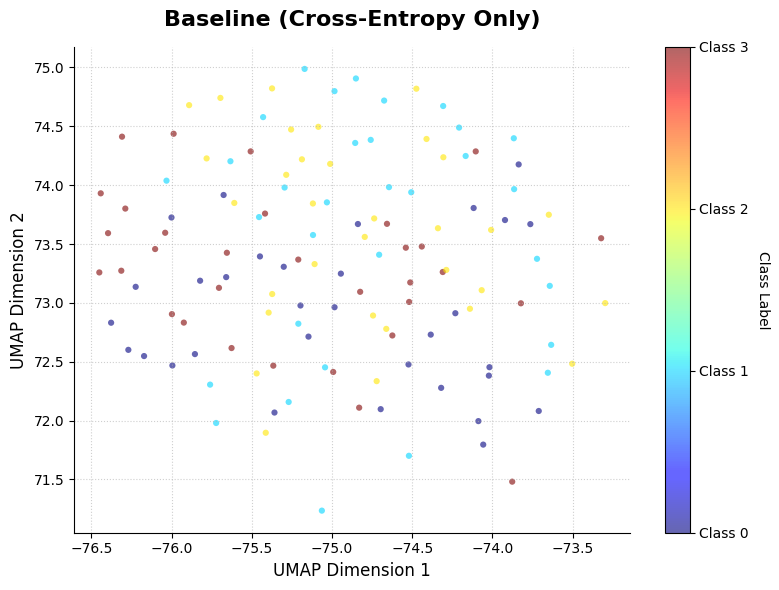

Projecting Proposed (CE + ICRR)...


c:\Users\roger\Desktop\vs_code\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


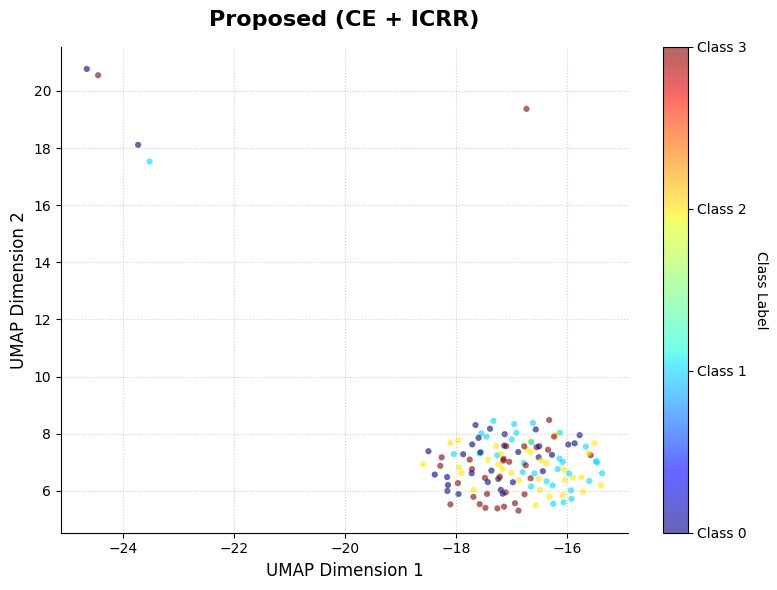

In [58]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. Configuration for "Clustered" Look
# ==========================================
# n_neighbors: Higher (30-50) focuses on global structure (separating clusters)
# min_dist: Lower (0.0-0.1) packs points tighter together
reducer = umap.UMAP(
    n_neighbors=50,      # Increased from default 15
    min_dist=0.01,       # Decreased from default 0.1
    n_components=2,
    metric='euclidean',
    random_state=42      # Fixed seed for reproducibility
)

def plot_publication_umap(embeddings, labels, title, save_name, reducer_model=None):
    """
    Plots embeddings using a consistent UMAP reducer.
    """
    # If a reducer is provided (fitted), use it. Otherwise, fit a new one.
    # NOTE: For strict comparison, we usually fit separate reducers with SAME params,
    # or fit on combined data. Fitting separate with same params is standard for 
    # comparing distribution shapes.
    
    print(f"Projecting {title}...")
    
    # Fit and transform the data
    # We create a NEW reducer instance with identical params for each to 
    # allow each manifold to form its own optimal shape based on the params.
    if reducer_model is None:
        local_reducer = umap.UMAP(
            n_neighbors=50, 
            min_dist=0.01, 
            metric='euclidean', 
            random_state=42
        )
        embedding_2d = local_reducer.fit_transform(embeddings)
    else:
        embedding_2d = reducer_model.transform(embeddings)

    # Plotting
    plt.figure(figsize=(8, 6))
    
    # specific colors for 4 classes (Motor Imagery)
    # 0: Left Hand, 1: Right Hand, 2: Both Feet, 3: Tongue (Example BNCI map)
    cmap_name = 'jet' # or 'viridis', 'Spectral'
    
    scatter = plt.scatter(
        embedding_2d[:, 0], 
        embedding_2d[:, 1], 
        c=labels, 
        cmap=cmap_name, 
        s=20,            # Dot size
        alpha=0.6,       # Transparency (helps see density)
        edgecolors='none'
    )
    
    # Aesthetic details for the paper
    plt.title(title, fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("UMAP Dimension 1", fontsize=12)
    plt.ylabel("UMAP Dimension 2", fontsize=12)
    
    # Clean grid
    plt.grid(True, linestyle=':', alpha=0.6)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ticks=[0, 1, 2, 3])
    cbar.set_label('Class Label', rotation=270, labelpad=15)
    cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3']) 
    
    # Remove top and right spines for a cleaner scientific look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Save high-res
    plt.tight_layout()
    plt.savefig(f"{save_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

# ==========================================
# 2. Execution (Run this with your data)
# ==========================================

# Assuming you have these variables from your previous notebook run:
# emb_ce  -> Embeddings from Baseline (Cross-Entropy only)
# emb_icr -> Embeddings from Proposed (ICRR)
# labels  -> The true class labels (y_val or y_test)

# Plot Baseline
plot_publication_umap(
    emb_ce, 
    labels, 
    title="Baseline (Cross-Entropy Only)", 
    save_name="Fig4_UMAP_Baseline"
)

# Plot Proposed
plot_publication_umap(
    emb_icr, 
    labels, 
    title="Proposed (CE + ICRR)", 
    save_name="Fig5_UMAP_ICRR"
)

In [59]:
ess_ce = compute_ess(emb_ce, labels)
ess_icr = compute_ess(emb_icr, labels)

print(f"ESS (CE): {ess_ce:.4f}")
print(f"ESS (CE + ICRR): {ess_icr:.4f}")


ESS (CE): 39.3044
ESS (CE + ICRR): 32.2505


In [53]:
def compute_classwise_ess(embeddings, labels):
    import numpy as np
    class_ess = {}
    for c in np.unique(labels):
        idx = labels == c
        class_emb = embeddings[idx]
        centroid = class_emb.mean(axis=0)
        class_ess[c] = np.mean(np.linalg.norm(class_emb - centroid, axis=1))
    return class_ess

print("CE class-wise ESS:", compute_classwise_ess(emb_ce, labels))
print("ICRR class-wise ESS:", compute_classwise_ess(emb_icr, labels))


CE class-wise ESS: {np.int64(0): np.float32(41.527138), np.int64(1): np.float32(39.835358), np.int64(2): np.float32(39.254025), np.int64(3): np.float32(36.601044)}
ICRR class-wise ESS: {np.int64(0): np.float32(33.219906), np.int64(1): np.float32(33.13718), np.int64(2): np.float32(32.179432), np.int64(3): np.float32(30.46556)}


In [54]:
import json

ess_results = {
    "ESS_CE": float(ess_ce),
    "ESS_CE_ICRR": float(ess_icr)
}

with open("ess_results.json", "w") as f:
    json.dump(ess_results, f, indent=4)


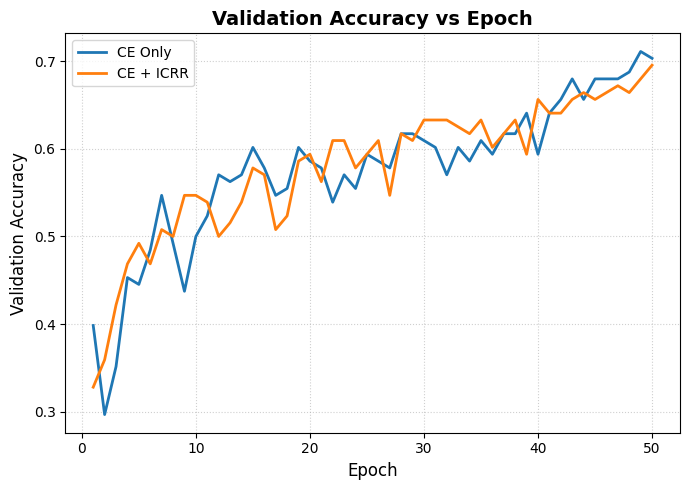

In [60]:
epochs = np.arange(1, len(hist_ce["val_acc"]) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs, hist_ce["val_acc"], label="CE Only", linewidth=2)
plt.plot(epochs, hist_icr["val_acc"], label="CE + ICRR", linewidth=2)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.title("Validation Accuracy vs Epoch", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig("Fig1_Validation_Accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

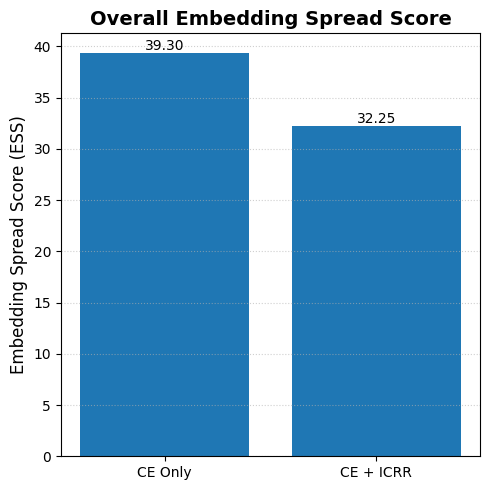

In [61]:
ess_values = [ess_ce, ess_icr]
labels = ["CE Only", "CE + ICRR"]

plt.figure(figsize=(5, 5))
bars = plt.bar(labels, ess_values)

plt.ylabel("Embedding Spread Score (ESS)", fontsize=12)
plt.title("Overall Embedding Spread Score", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle=":", alpha=0.6)

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.savefig("Fig2_Overall_ESS.png", dpi=300, bbox_inches="tight")
plt.show()


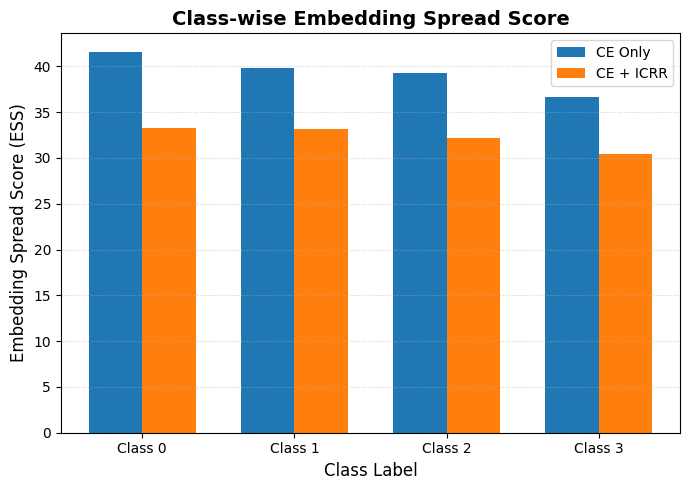

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# --- SAFETY: re-extract labels cleanly ---
_, clean_labels = extract_embeddings(model_ce, val_loader, device)

# --- Recompute class-wise ESS cleanly ---
def compute_classwise_ess_safe(embeddings, labels):
    class_ess = {}
    for c in np.unique(labels):
        idx = labels == c
        class_emb = embeddings[idx]
        centroid = class_emb.mean(axis=0)
        class_ess[int(c)] = np.mean(
            np.linalg.norm(class_emb - centroid, axis=1)
        )
    return class_ess

ce_classwise = compute_classwise_ess_safe(emb_ce, clean_labels)
icr_classwise = compute_classwise_ess_safe(emb_icr, clean_labels)

# --- Prepare plot values ---
classes = sorted(ce_classwise.keys())
ce_vals = [ce_classwise[c] for c in classes]
icr_vals = [icr_classwise[c] for c in classes]

x = np.arange(len(classes))
width = 0.35

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.bar(x - width/2, ce_vals, width, label="CE Only")
plt.bar(x + width/2, icr_vals, width, label="CE + ICRR")

plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Embedding Spread Score (ESS)", fontsize=12)
plt.title("Class-wise Embedding Spread Score", fontsize=14, fontweight="bold")
plt.xticks(x, [f"Class {c}" for c in classes])
plt.legend()
plt.grid(axis="y", linestyle=":", alpha=0.6)

plt.tight_layout()
plt.savefig("Fig3_Classwise_ESS.png", dpi=300, bbox_inches="tight")
plt.show()

